In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
# import datetime
import os
import gc
# from sklearn.preprocessing import LabelEncoder

import lightgbm as lgb

import geobleu
from joblib import Parallel, delayed
from tqdm import tqdm

#　擬似スコア
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score

from sklearn.model_selection import GroupKFold
from collections import Counter, defaultdict

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append("../src")

import importlib
from util import *
import util

from calc_metrices import *
import calc_metrices

In [2]:
class Config:

  exp = 'ens104'
  task = 'task2'
  data = 'CB'
  stage = "test"
  
  # candidate hypara. group window_size
  window_size = 3
  co_start_day = 0
  co_end_day = 59

  # co-visitation matrix
  n_ago = 3
  
  # train test split. taskごとに要変更
  # start_uid = 60000
  # end_uid = 69999
  train_start_day = 0
  train_end_day = 59
  test_start_day = 60
  test_end_day = 74

  # train, valid split. taskごとに要変更
  model_train_start_day = 0
  model_train_end_day = 40
  model_valid_start_day = 41
  model_valid_end_day = 59

  seed = 123
  debug = False


In [3]:
# INPUT_DIR = f'/root/humob/input/pkl/' #各自データがあるパスに変更の必要あり
DATA_DIR = f'/root/humob/pub/data/{Config.task}/{Config.data}/'
# if not os.path.exists(OUTPUT_DIR):
#   os.makedirs(OUTPUT_DIR)
# if not os.path.exists(OUTPUT_DIR+Config.stage):
#   os.makedirs(OUTPUT_DIR+Config.stage)

In [4]:
all_days = [i for i in range(75)]
train_weekend_list = [0, 1, 6, 7, 8, 13, 14, 20, 21, 27, 28, 29, 34, 35, 37, 41, 42, 48, 49, 50, 55, 56,]
test_not_normal_day = [65, 66, 67, 72, 73]
weekend_list = train_weekend_list + test_not_normal_day
weekday_list = [day for day in all_days if day not in weekend_list]

In [5]:
## Features to train the model
FEATURES = ['log_len', 'log_len_mean', 'log_len_median', 'log_len_skew',
       'log_len_std', 'over_d',
       't0_11_cnt', 't12_23_cnt', 't24_35_cnt', 't36_47_cnt', 'top1_ratio',
       'wd', 'wd_flag', 'wd_log_len_mean', 'wd_log_len_median',
       'wd_log_len_skew', 'wd_log_len_std', 'xy_nunique']

In [6]:
# lgbm_t_grt_make_data_train.ipynb実行済みであることを前提とする
pqt_list = list_pqt_files(DATA_DIR+Config.stage)

In [7]:
train_df = pd.concat([pd.read_parquet(f"{DATA_DIR}/train/{pqt}") for pqt in pqt_list],axis=1)
valid_df = pd.concat([pd.read_parquet(f"{DATA_DIR}/valid/{pqt}") for pqt in pqt_list],axis=1)
test_df = pd.concat([pd.read_parquet(f"{DATA_DIR}/test/{pqt}") for pqt in pqt_list],axis=1)

In [8]:
train_df["target"] = (train_df["pred_t_geobleu"] > train_df["pred_group_t_geobleu"]) # 出し分けのためのtarget設定

In [9]:
# GroupKFold
gkf = GroupKFold(n_splits=4)
for fold,(train_index, test_index) in enumerate(gkf.split(train_df[FEATURES], train_df['target'], train_df["uid"])):
    train_df.loc[test_index, "group"] = fold

## RF

In [10]:
train_df["proba"] = -1
rf_models = []
model_path = f"{DATA_DIR}/rf004_CB_models.pkl"

if check_exist_file(model_path):
    print("trained model exists, loading…")
    rf_models = load_file(model_path)
for i in range(4):
    print(f"----- fold {i} -------")
    X_train, y_train = train_df.loc[train_df.group!=i][FEATURES], train_df.loc[train_df.group!=i]["target"]
    X_valid, y_valid = train_df.loc[train_df.group==i][FEATURES], train_df.loc[train_df.group==i]["target"]    
    if check_exist_file(model_path):
        rf_models = load_file(model_path)
    else:
        model = RandomForestClassifier(max_depth=6,
                                    max_features=0.50,
                                    n_estimators=500,
                                    random_state=2023
                                    )
        model.fit(X_train, y_train)
        rf_models.append(model)
    y_pred = rf_models[i].predict_proba(X_valid)
    train_df.loc[train_df.group==i,f"rf_proba{i}"] = y_pred[:,1]
    print(f"acc : {accuracy_score((y_pred[:,1]>0.5),y_valid)}")
    print(f"f1 : {f1_score((y_pred[:,1]>0.5),y_valid)}")
if not check_exist_file(model_path):
    save_file(rf_models, model_path)

----- fold 0 -------
acc : 0.5885347197648148
f1 : 0.6528728241399898
----- fold 1 -------
acc : 0.6004028635980074
f1 : 0.6612437983154493
----- fold 2 -------
acc : 0.5947490915030011
f1 : 0.6518724643103508
----- fold 3 -------
acc : 0.5924161585365854
f1 : 0.6557851904641485


## LGBM

In [11]:
# train_df["lgb_proba"] = -1
lgb_models = []
lgb_model_path = f"{DATA_DIR}/{Config.exp}_lgbmodels.pkl"

if check_exist_file(lgb_model_path):
    models = load_file(lgb_model_path)

for i in range(4):
    print(f"----- fold {i} -------")
    X_train, y_train = train_df.loc[train_df.group!=i][FEATURES], train_df.loc[train_df.group!=i]["target"]
    X_valid, y_valid = train_df.loc[train_df.group==i][FEATURES], train_df.loc[train_df.group==i]["target"]

    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_valid = lgb.Dataset(X_valid, label=y_valid)

    if check_exist_file(lgb_model_path):
        models = load_file(lgb_model_path)
    else:
        params = {
            'objective': 'binary',
            'metric': 'binary_logloss'
        }

        model = lgb.train(params, lgb_train,
                          valid_sets=[lgb_valid],
                          num_boost_round=10000,
                          callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=True)]
                )

        lgb_models.append(model)

    y_pred = lgb_models[i].predict(X_valid)
    train_df.loc[train_df.group==i, f"lgb_proba{i}"] = y_pred

    threshold = 0.5  # This threshold can be tuned based on the requirement
    print(f"acc : {accuracy_score((y_pred > threshold).astype(int), y_valid)}")
    print(f"f1 : {f1_score((y_pred > threshold).astype(int), y_valid)}")

train_df["lgb_proba"] = train_df[["lgb_proba0", "lgb_proba1", "lgb_proba2", "lgb_proba3"]].mean(axis=1)

----- fold 0 -------
[LightGBM] [Info] Number of positive: 117662, number of negative: 102757
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 220419, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.533811 -> initscore=0.135449
[LightGBM] [Info] Start training from score 0.135449
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.666777
acc : 0.5924136429213055
f1 : 0.6445586507305379
----- fold 1 -------
[LightGBM] [Info] Number of positive: 117138, number of negative: 103281
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002095 seconds.
You can set `force_row_wise=true` to 

## XGB

In [12]:
import xgboost as xgb

train_df["xgb_proba"] = -1
xgb_models = []
xgb_model_path = f"{DATA_DIR}/{Config.exp}_xgbmodels.pkl"

if check_exist_file(xgb_model_path):
    xgb_models = load_file(xgb_model_path)
    
for i in range(4):
    print(f"----- fold {i} -------")
    X_train, y_train = train_df.loc[train_df.group!=i][FEATURES], train_df.loc[train_df.group!=i]["target"]
    X_valid, y_valid = train_df.loc[train_df.group==i][FEATURES], train_df.loc[train_df.group==i]["target"]

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_valid, label=y_valid)

    if check_exist_file(xgb_model_path):
        xgb_models = load_file(xgb_model_path)
    else:
        param = {'objective': 'binary:logistic'}
        evaluation_results = {}
        model = xgb.train(param,
                        dtrain,
                        num_boost_round=10000,
                        early_stopping_rounds=10,
                        evals=[(dtrain, 'train'), (dvalid, 'eval')],
                        evals_result=evaluation_results,
                        verbose_eval=10
                        )

        xgb_models.append(model)


    y_pred = xgb_models[i].predict(dvalid)
    train_df.loc[train_df.group==i,f"xgb_proba{i}"] = y_pred

    threshold = 0.5  # This threshold can be tuned based on the requirement
    print(f"acc : {accuracy_score((y_pred > threshold).astype(int), y_valid)}")
    print(f"f1 : {f1_score((y_pred > threshold).astype(int), y_valid)}")
train_df["xgb_proba"] = train_df[["xgb_proba0", "xgb_proba1", "xgb_proba2", "xgb_proba3"]].mean(axis=1)

----- fold 0 -------
[0]	train-logloss:0.67916	eval-logloss:0.68097
[10]	train-logloss:0.65491	eval-logloss:0.66758
[20]	train-logloss:0.64976	eval-logloss:0.66787
[25]	train-logloss:0.64812	eval-logloss:0.66813
acc : 0.5908076326319515
f1 : 0.6446931467671981
----- fold 1 -------
[0]	train-logloss:0.68006	eval-logloss:0.67997
[10]	train-logloss:0.65666	eval-logloss:0.66332
[20]	train-logloss:0.65136	eval-logloss:0.66369
[21]	train-logloss:0.65119	eval-logloss:0.66372
acc : 0.5972180635326783
f1 : 0.6500981342665941
----- fold 2 -------
[0]	train-logloss:0.67980	eval-logloss:0.68054
[10]	train-logloss:0.65628	eval-logloss:0.66424
[18]	train-logloss:0.65159	eval-logloss:0.66471
acc : 0.5949124168061737
f1 : 0.6438597121010877
----- fold 3 -------
[0]	train-logloss:0.67962	eval-logloss:0.68049
[10]	train-logloss:0.65618	eval-logloss:0.66523
[20]	train-logloss:0.65122	eval-logloss:0.66517
[26]	train-logloss:0.64847	eval-logloss:0.66568
acc : 0.5958324259581882
f1 : 0.6455978708422347


## Catboost

In [13]:
import catboost as cb

train_df["cat_proba"] = -1
cat_models = []
cat_model_path = f"{DATA_DIR}/{Config.exp}_catmodels.pkl"

if check_exist_file(cat_model_path):
    cat_models = load_file(cat_model_path)
    
for i in range(4):
    print(f"----- fold {i} -------")
    X_train, y_train = train_df.loc[train_df.group!=i][FEATURES], train_df.loc[train_df.group!=i]["target"]
    X_valid, y_valid = train_df.loc[train_df.group==i][FEATURES], train_df.loc[train_df.group==i]["target"]

    train_dataset = cb.Pool(X_train, y_train)
    valid_dataset = cb.Pool(X_valid, y_valid)

    if check_exist_file(cat_model_path):
        cat_models = load_file(cat_model_path)
    else:
        model = cb.CatBoostClassifier(iterations=10000,
                                      eval_metric='Logloss',
                                      early_stopping_rounds=10,
                                      verbose=1000)
        model.fit(train_dataset, eval_set=valid_dataset)

        cat_models.append(model)

    y_pred = cat_models[i].predict_proba(valid_dataset)[:, 1]
    train_df.loc[train_df.group==i, f"cat_proba{i}"] = y_pred

    threshold = 0.5  # This threshold can be tuned based on the requirement
    print(f"acc : {accuracy_score((y_pred > threshold).astype(int), y_valid)}")
    print(f"f1 : {f1_score((y_pred > threshold).astype(int), y_valid)}")

train_df["cat_proba"] = train_df[["cat_proba0", "cat_proba1", "cat_proba2", "cat_proba3"]].mean(axis=1)

----- fold 0 -------
Learning rate set to 0.044126
0:	learn: 0.6911667	test: 0.6913248	best: 0.6913248 (0)	total: 58.5ms	remaining: 9m 45s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.6668654741
bestIteration = 233

Shrink model to first 234 iterations.
acc : 0.591937283937175
f1 : 0.6464720309404773
----- fold 1 -------
Learning rate set to 0.044126
0:	learn: 0.6913056	test: 0.6912199	best: 0.6912199 (0)	total: 11.4ms	remaining: 1m 54s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.6621522717
bestIteration = 263

Shrink model to first 264 iterations.
acc : 0.6010017148923429
f1 : 0.6544717363632077
----- fold 2 -------
Learning rate set to 0.044126
0:	learn: 0.6912677	test: 0.6912637	best: 0.6912637 (0)	total: 12.4ms	remaining: 2m 3s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.6623004583
bestIteration = 290

Shrink model to first 291 iterations.
acc : 0.5992541477821784
f1 : 0.6472758637213091
----- fold 3 -------
Lea

In [14]:
train_df["proba"] = train_df[["lgb_proba0", "lgb_proba1", "lgb_proba2", "lgb_proba3",
                              "cat_proba0", "cat_proba1", "cat_proba2", "cat_proba3",
                              "xgb_proba0", "xgb_proba1", "xgb_proba2", "xgb_proba3",
                              "rf_proba0", "rf_proba1", "rf_proba2", "rf_proba3"
                              ]].mean(axis=1)

In [15]:
def calc_ml_geobleu(train_df, proba, thr):

    train_df.loc[train_df[proba]>thr,"pred_score"] =  train_df.loc[train_df[proba]>thr, "pred_t_geobleu"]
    train_df.loc[train_df[proba]<=thr,"pred_score"] =  train_df.loc[train_df[proba]<=thr, "pred_group_t_geobleu"]

    print(f"weekday",np.mean(train_df.loc[train_df.d.isin(weekday_list)].groupby("uid")["pred_score"].mean()))
    print(f"weekend",np.mean(train_df.loc[train_df.d.isin(weekend_list)].groupby("uid")["pred_score"].mean()))
    # print(f"weekend : {weekend_t_score*(weekend_t_df.shape[0]/weekend_df.shape[0]) + weekend_grt_score*(weekend_grt_df.shape[0]/weekend_df.shape[0])}")

    geobleu_score = np.mean(train_df.groupby(["uid"])["pred_score"].mean())
    return geobleu_score
    
thr = 0.55 # train_dfでthr調整した.
print("train score")

train score


weekday 0.2469817133174549


weekend 0.21143829511972764
weekday 0.24704306463066722
weekend 0.21319750338076057
weekday 0.24713250200159592
weekend 0.2147383402794173
weekday 0.24723179196773262
weekend 0.21595166613152647
weekday 0.247330011558158
weekend 0.21695257845438523
weekday 0.24756986009533322
weekend 0.21785740520649513
weekday 0.24782321301289367
weekend 0.21866804919595184
weekday 0.24813182576090395
weekend 0.2192435903359025
weekday 0.24849368585669357
weekend 0.21982084823565046
weekday 0.24875145657415124
weekend 0.22018545626724795
weekday 0.24903748883650292
weekend 0.22054756273530324
weekday 0.24916942914258902
weekend 0.22074361804985443
weekday 0.24935303073842943
weekend 0.22087784067780447
weekday 0.24944620865169487
weekend 0.2209981456773887
weekday 0.24942190016422977
weekend 0.22102874886317794
weekday 0.24931332597427122
weekend 0.22099485671593042
weekday 0.24911125614486554
weekend 0.22096594446592827
weekday 0.248861597464339
weekend 0.2209876708051052
weekday 0.2485237667977627
w

Text(0.5, 1.0, 'ensamble train thr-geobleu curve')

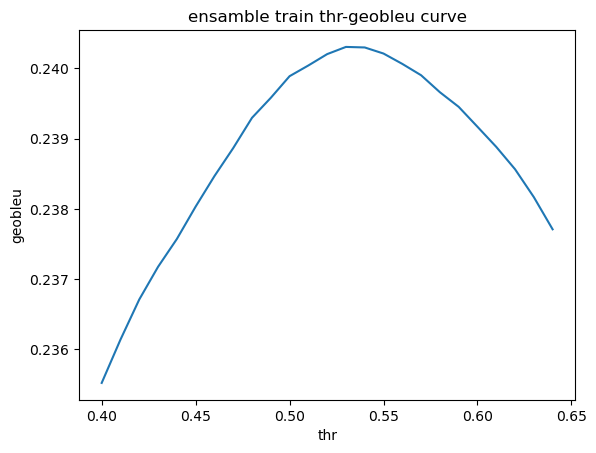

In [16]:
thr_list = [0.40+i*0.01 for i in range(0, 25)]
fig, ax = plt.subplots()
geobleu_list = [calc_ml_geobleu(train_df, "proba", thr=thr) for thr in thr_list]
print(np.max(geobleu_list), thr_list[np.argmax(geobleu_list)])
ax.plot(thr_list, geobleu_list)
ax.set_xlabel("thr")
ax.set_ylabel("geobleu")
ax.set_title("ensamble train thr-geobleu curve")

## Valid

In [17]:
models_list = [lgb_models, cat_models, xgb_models, rf_models]

In [18]:
for name, models in zip(["lgb", "cat", "xgb", "rf"], models_list):
    print(name)
    for i, model in enumerate(models):
        if name == "xgb":
            valid_df[f"{name}_proba{i}"] = model.predict(xgb.DMatrix(valid_df[FEATURES]))
        elif name == "lgb":
            valid_df[f"{name}_proba{i}"] = model.predict(valid_df[FEATURES])
        else:
            valid_df[f"{name}_proba{i}"] = model.predict_proba(valid_df[FEATURES])[:,1]

lgb


cat
xgb
rf


In [19]:
valid_df["proba"] = valid_df[["lgb_proba0", "lgb_proba1", "lgb_proba2", "lgb_proba3",
                              "cat_proba0", "cat_proba1", "cat_proba2", "cat_proba3",
                              "xgb_proba0", "xgb_proba1", "xgb_proba2", "xgb_proba3",
                              "rf_proba0", "rf_proba1", "rf_proba2", "rf_proba3"
                              ]].mean(axis=1)

In [20]:
print("valid score")
thr = 0.53
calc_ml_geobleu(valid_df, "proba",thr=thr)

valid score
weekday 0.23911921243463957
weekend 0.1972293851990041


0.2254267184996922

weekday 0.23672995013671275
weekend 0.18539023864478618
weekday 0.23675984409183792
weekend 0.1879859867851863
weekday 0.23680017579869445
weekend 0.19004786088010023
weekday 0.23695304345742324
weekend 0.1915750746225797
weekday 0.23707499572433235
weekend 0.19282966105849278
weekday 0.23730141042340455
weekend 0.19407240841177203
weekday 0.2376963513590863
weekend 0.19499889133786058
weekday 0.23809375538303612
weekend 0.19573410617695242
weekday 0.23838203431708702
weekend 0.19617850101619436
weekday 0.2387662555670932
weekend 0.19647325366553933
weekday 0.2389801410648674
weekend 0.1968994608592359
weekday 0.23910928281536126
weekend 0.1971896852192804
weekday 0.23917069968853372
weekend 0.19717015567497093
weekday 0.23911921243463957
weekend 0.1972293851990041
weekday 0.23912824847494504
weekend 0.1971380400748875
weekday 0.23890281342501407
weekend 0.19723593394922526
weekday 0.2385080334912819
weekend 0.19732306209183298
weekday 0.23809996696026414
weekend 0.19727162884329377
we

Text(0.5, 1.0, 'ensamble valid thr-geobleu curve')

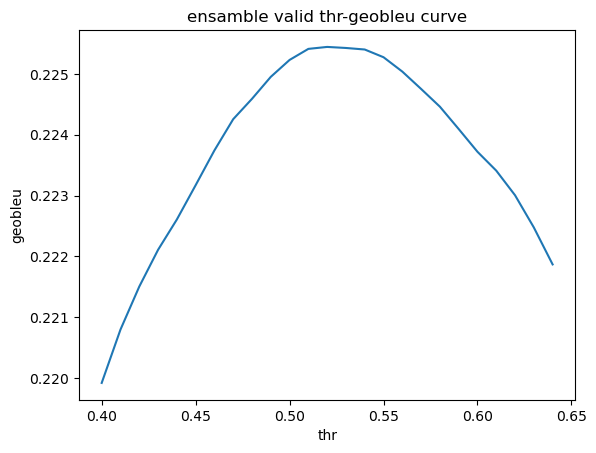

In [21]:
thr_list = [0.40+i*0.01 for i in range(0, 25)]
fig, ax = plt.subplots()
geobleu_list = [calc_ml_geobleu(valid_df, "proba", thr=thr) for thr in thr_list]
print(np.max(geobleu_list), thr_list[np.argmax(geobleu_list)])
ax.plot(thr_list, geobleu_list)
ax.set_xlabel("thr")
ax.set_ylabel("geobleu")
ax.set_title("ensamble valid thr-geobleu curve")

In [22]:
valid_df[["uid" ,"d", "wd", "proba"]].to_csv(f"{DATA_DIR}/valid_ensamble_output.csv", index=False)

## Test

In [23]:
for name, models in zip(["lgb", "cat", "xgb", "rf"], models_list):
    print(name)
    for i, model in enumerate(models):
        if name == "xgb":
            test_df[f"{name}_proba{i}"] = model.predict(xgb.DMatrix(test_df[FEATURES]))
        elif name == "lgb":
            test_df[f"{name}_proba{i}"] = model.predict(test_df[FEATURES])
        else:
            test_df[f"{name}_proba{i}"] = model.predict_proba(test_df[FEATURES])[:,1]

lgb
cat
xgb
rf


In [24]:
test_df["proba"] = test_df[["lgb_proba0", "lgb_proba1", "lgb_proba2", "lgb_proba3",
                              "cat_proba0", "cat_proba1", "cat_proba2", "cat_proba3",
                              "xgb_proba0", "xgb_proba1", "xgb_proba2", "xgb_proba3",
                              "rf_proba0", "rf_proba1", "rf_proba2", "rf_proba3"
                              ]].mean(axis=1)

In [25]:
test_df[["uid" ,"d", "wd", "proba"]].to_csv(f"{DATA_DIR}/test_ensamble_output.csv", index=False)

EOF